
# Desafio: Previsão de Evasão de Clientes

Sua nova missão é desenvolver modelos preditivos capazes de prever quais clientes têm maior chance de cancelar seus serviços.

A empresa quer antecipar o problema da evasão, e cabe a você construir um pipeline robusto para essa etapa inicial de modelagem.

## Objetivos do Desafio
- Preparar os dados para a modelagem (tratamento, encoding, normalização).
- Realizar análise de correlação e seleção de variáveis.
- Treinar dois ou mais modelos de classificação.
- Avaliar o desempenho dos modelos com métricas.
- Interpretar os resultados, incluindo a importância das variáveis.
- Criar uma conclusão estratégica apontando os principais fatores que influenciam a evasão.

## O que você vai praticar
- Pré-processamento de dados para Machine Learning
- Construção e avaliação de modelos preditivos
- Interpretação dos resultados e entrega de insights
- Comunicação técnica com foco estratégico


In [1]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')



In [2]:

# Lendo os dados do arquivo JSON fornecido
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Telecom')

import pandas as pd
df = pd.read_json('TelecomX_Data.json')
print(df.shape)
df.head()



Mounted at /content/drive
(7267, 6)


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


In [3]:
# 2. Limpeza e diagnóstico
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print("Após limpeza, df.shape:", df.shape)
print("Valores ausentes:")
print(df.isnull().sum())
df = df.dropna()
print("Após dropna, df.shape:", df.shape)

# Split SEMPRE após o dropna
X = df.drop('Churn', axis=1)
y = df['Churn']

print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Nulos em y:", y.isnull().sum())
print("Valores únicos em y:", y.unique())

Após limpeza, df.shape: (7267, 5)
Valores ausentes:
Churn       0
customer    0
phone       0
internet    0
account     0
dtype: int64
Após dropna, df.shape: (7267, 5)
Shape X: (7267, 4)
Shape y: (7267,)
Nulos em y: 0
Valores únicos em y: ['No' 'Yes' '']


In [4]:

# Transformando coluna alvo para binário
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})


In [5]:

# 4. Split de features e alvo
X = df.drop('Churn', axis=1)
y = df['Churn']

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print("Categóricas:", categorical_cols)
print("Numéricas:", numeric_cols)
print("X shape:", X.shape)
print("y shape:", y.shape)



Categóricas: ['customer', 'phone', 'internet', 'account']
Numéricas: []
X shape: (7267, 4)
y shape: (7267,)


In [6]:
# 5. Tratamento seguro das features categóricas (para evitar DataFrame vazio)
for col in categorical_cols:
    X[col] = X[col].fillna('desconhecido').astype(str)
print("Checagem dos tipos das colunas categóricas:")
for col in categorical_cols:
    print(f"{col}: tipos únicos ->", X[col].apply(type).unique())
    print(f"{col}: exemplos ->", X[col].unique()[:10])





Checagem dos tipos das colunas categóricas:
customer: tipos únicos -> [<class 'str'>]
customer: exemplos -> ["{'gender': 'Female', 'SeniorCitizen': 0, 'Partner': 'Yes', 'Dependents': 'Yes', 'tenure': 9}"
 "{'gender': 'Male', 'SeniorCitizen': 0, 'Partner': 'No', 'Dependents': 'No', 'tenure': 9}"
 "{'gender': 'Male', 'SeniorCitizen': 0, 'Partner': 'No', 'Dependents': 'No', 'tenure': 4}"
 "{'gender': 'Male', 'SeniorCitizen': 1, 'Partner': 'Yes', 'Dependents': 'No', 'tenure': 13}"
 "{'gender': 'Female', 'SeniorCitizen': 1, 'Partner': 'Yes', 'Dependents': 'No', 'tenure': 3}"
 "{'gender': 'Female', 'SeniorCitizen': 0, 'Partner': 'No', 'Dependents': 'Yes', 'tenure': 9}"
 "{'gender': 'Female', 'SeniorCitizen': 1, 'Partner': 'Yes', 'Dependents': 'No', 'tenure': 71}"
 "{'gender': 'Male', 'SeniorCitizen': 0, 'Partner': 'Yes', 'Dependents': 'No', 'tenure': 63}"
 "{'gender': 'Female', 'SeniorCitizen': 1, 'Partner': 'No', 'Dependents': 'No', 'tenure': 7}"
 "{'gender': 'Female', 'SeniorCitizen': 0, '

In [7]:
# 6. OneHotEncoding seguro
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)

X_encoded = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
print("Shape pós-encoding:", X_encoded.shape)

import numpy as np
print("Valores únicos por coluna:")
for i, fname in enumerate(feature_names):
    print(f"{fname}: {np.unique(X_encoded[:, i])}")


A saída de streaming foi truncada nas últimas 5000 linhas.
cat__account_{'Contract': 'Month-to-month', 'PaperlessBilling': 'Yes', 'PaymentMethod': 'Credit card (automatic)', 'Charges': {'Monthly': 90.85, 'Total': '4515.85'}}: [0. 1.]
cat__account_{'Contract': 'Month-to-month', 'PaperlessBilling': 'Yes', 'PaymentMethod': 'Credit card (automatic)', 'Charges': {'Monthly': 90.85, 'Total': '90.85'}}: [0. 1.]
cat__account_{'Contract': 'Month-to-month', 'PaperlessBilling': 'Yes', 'PaymentMethod': 'Credit card (automatic)', 'Charges': {'Monthly': 90.95, 'Total': '1612.2'}}: [0. 1.]
cat__account_{'Contract': 'Month-to-month', 'PaperlessBilling': 'Yes', 'PaymentMethod': 'Credit card (automatic)', 'Charges': {'Monthly': 91.05, 'Total': '4370.75'}}: [0. 1.]
cat__account_{'Contract': 'Month-to-month', 'PaperlessBilling': 'Yes', 'PaymentMethod': 'Credit card (automatic)', 'Charges': {'Monthly': 91.5, 'Total': '242.95'}}: [0. 1.]
cat__account_{'Contract': 'Month-to-month', 'PaperlessBilling': 'Yes', 

Shape de X_encoded: (7043, 7954)
Shape de y: (7043,)
NaN em X_encoded? False
NaN em y? False
Distribuição pós-SMOTE: [5174 5174]


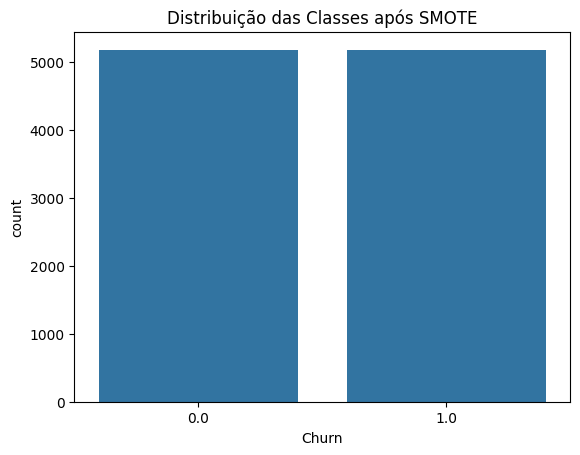

In [8]:
# 7. Balanceamento com SMOTE

from imblearn.over_sampling import SMOTE

# Remover linhas com NaN em y
mask = ~pd.isnull(y)
X_encoded = X_encoded[mask]
y = y[mask]

# Diagnóstico rápido (pode até remover depois de testar!)
print("Shape de X_encoded:", X_encoded.shape)
print("Shape de y:", y.shape)
print("NaN em X_encoded?", np.isnan(X_encoded).any())
print("NaN em y?", pd.isnull(y).any())

# Rodar SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_encoded, y)
print("Distribuição pós-SMOTE:", np.bincount(y_res))
sns.countplot(x=y_res)
plt.title("Distribuição das Classes após SMOTE")
plt.show()



In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split (uma vez só!)
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42, stratify=y_res
)

# Normalização (apenas para modelos que precisam)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [10]:
# 10. Correlação entre variáveis numéricas originais
if len(numeric_cols) > 0:
    corr = df[numeric_cols + ['Churn']].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Matriz de Correlação')
    plt.show()



In [11]:
# 11. Modelos preditivos
# Regressão Logística (normalizado)
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Random Forest (não precisa normalização)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# KNN (normalizado)
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)


In [12]:
# 12. Avaliação dos modelos
def avaliar_modelo(y_true, y_pred, nome):
    print(f"\\n== {nome} ==")
    print("Acurácia:", accuracy_score(y_true, y_pred))
    print("Precisão:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-Score:", f1_score(y_true, y_pred))
    print("Matriz de Confusão:\\n", confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

avaliar_modelo(y_test, y_pred_lr, "Regressão Logística")
avaliar_modelo(y_test, y_pred_rf, "Random Forest")
avaliar_modelo(y_test, y_pred_knn, "KNN")



\n== Regressão Logística ==
Acurácia: 0.8785829307568438
Precisão: 0.8244064053009387
Recall: 0.9619845360824743
F1-Score: 0.887897710377639
Matriz de Confusão:\n [[1235  318]
 [  59 1493]]
              precision    recall  f1-score   support

         0.0       0.95      0.80      0.87      1553
         1.0       0.82      0.96      0.89      1552

    accuracy                           0.88      3105
   macro avg       0.89      0.88      0.88      3105
weighted avg       0.89      0.88      0.88      3105

\n== Random Forest ==
Acurácia: 0.8830917874396135
Precisão: 0.911988911988912
Recall: 0.8479381443298969
F1-Score: 0.8787979966611018
Matriz de Confusão:\n [[1426  127]
 [ 236 1316]]
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89      1553
         1.0       0.91      0.85      0.88      1552

    accuracy                           0.88      3105
   macro avg       0.88      0.88      0.88      3105
weighted avg       0.88    

\nTop 10 variáveis (Regressão Logística):
                                                feature      coef
1022  cat__internet_{'InternetService': 'No', 'Onlin... -0.771954
445   cat__customer_{'gender': 'Male', 'SeniorCitize...  0.552035
584   cat__customer_{'gender': 'Male', 'SeniorCitize...  0.523397
959   cat__internet_{'InternetService': 'Fiber optic...  0.502178
958   cat__internet_{'InternetService': 'Fiber optic...  0.471076
10    cat__customer_{'gender': 'Female', 'SeniorCiti...  0.461150
1973  cat__account_{'Contract': 'Month-to-month', 'P...  0.453462
3207  cat__account_{'Contract': 'Month-to-month', 'P...  0.450230
961   cat__internet_{'InternetService': 'Fiber optic...  0.400152
275   cat__customer_{'gender': 'Female', 'SeniorCiti...  0.378665
\nTop 10 variáveis (Random Forest):
                                                feature  importance
1022  cat__internet_{'InternetService': 'No', 'Onlin...    0.041646
958   cat__internet_{'InternetService': 'Fiber optic...    0

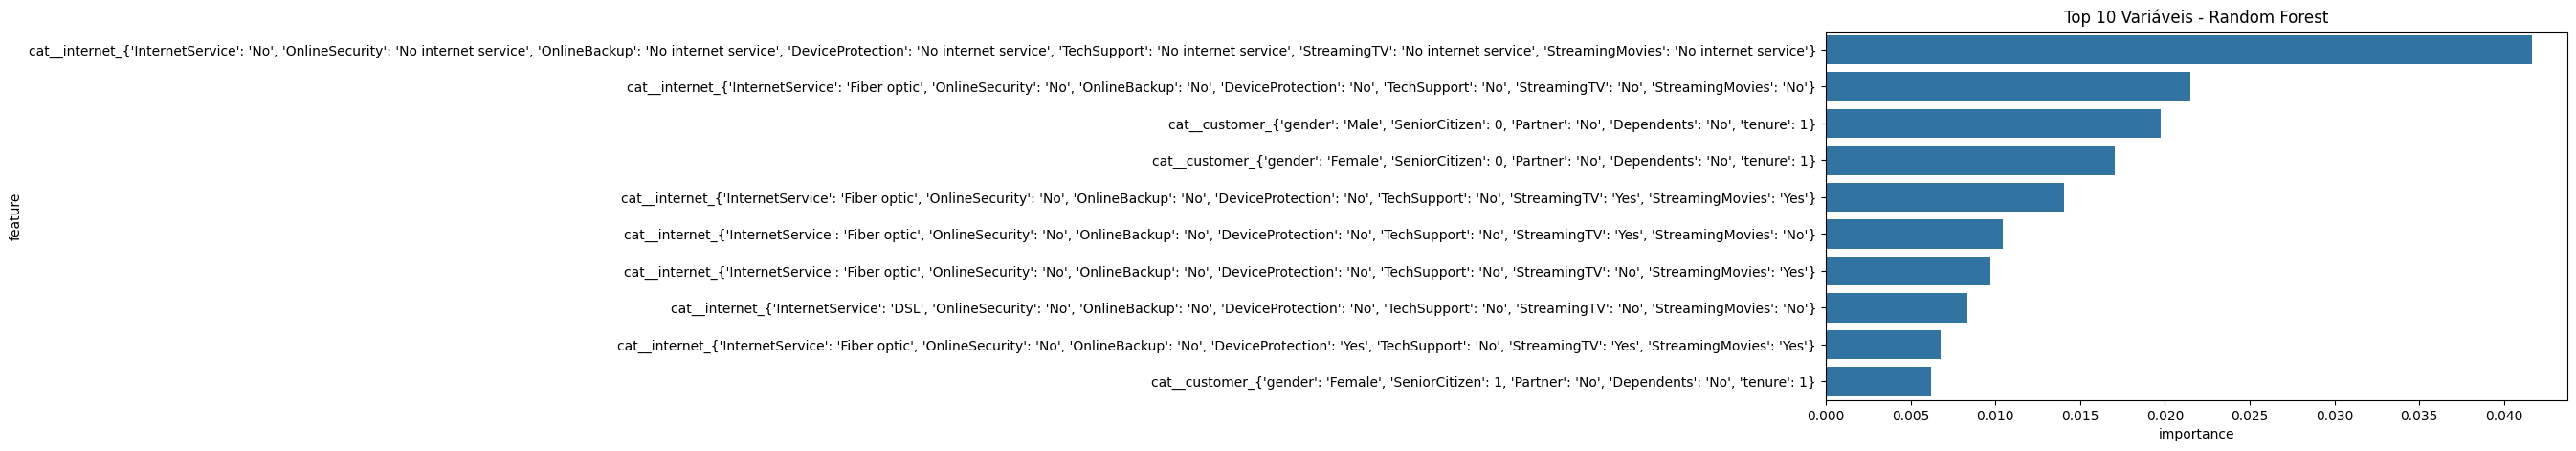

In [13]:
# 13. Importância das variáveis
# Regressão Logística
coef_lr = lr.coef_[0]
importancia_lr = pd.DataFrame({'feature': feature_names, 'coef': coef_lr})
importancia_lr['abs_coef'] = importancia_lr['coef'].abs()
importancia_lr = importancia_lr.sort_values(by='abs_coef', ascending=False)
print("\\nTop 10 variáveis (Regressão Logística):")
print(importancia_lr[['feature','coef']].head(10))

# Random Forest
importancias_rf = pd.DataFrame({'feature': feature_names, 'importance': rf.feature_importances_})
importancias_rf = importancias_rf.sort_values(by='importance', ascending=False)
print("\\nTop 10 variáveis (Random Forest):")
print(importancias_rf.head(10))

plt.figure(figsize=(10,5))
sns.barplot(x='importance', y='feature', data=importancias_rf.head(10))
plt.title('Top 10 Variáveis - Random Forest')
plt.show()



In [14]:
# Diretrizes – Previsão de Evasão de Clientes (Churn)

## Objetivo
Antecipar a evasão de clientes para apoiar estratégias de retenção.

## Pipeline
- Limpeza de dados (removendo customerID, convertendo TotalCharges e eliminando nulos)
- Balanceamento das classes com SMOTE
- One-hot encoding das variáveis categóricas
- Split treino/teste (70/30)
- Modelos: Regressão Logística (com normalização), Random Forest (sem), KNN (com normalização)

## Avaliação
Veja acima as métricas de Acurácia, Precisão, Recall, F1-Score e matriz de confusão para os três modelos.

## Análise Crítica
Compare os desempenhos e possíveis overfitting/underfitting. Reavalie hiperparâmetros se necessário.

## Principais Variáveis
- Regressão Logística: veja top 10 coeficientes acima
- Random Forest: veja gráfico top 10 acima

## Estratégias de Retenção
- Monitorar clientes em alto risco segundo as variáveis mais relevantes
- Implementar campanhas de engajamento, descontos ou ofertas personalizadas para perfis críticos
- Investir em experiência e atendimento para reduzir churn nos segmentos mais vulneráveis

## Conclusão
Os modelos mostram potencial para prever churn e direcionar ações mais assertivas. Recomenda-se revisar periodicamente e recalibrar os modelos com dados atualizados.


SyntaxError: invalid syntax (ipython-input-14-2435870817.py, line 4)

In [ ]:
## Relatório Final: Importância das variáveis no modelo Random Forest

O gráfico citado acima destaca as 10 variáveis mais importantes para previsão de evasão de clientes segundo o modelo Random Forest:

- **O principal fator de importância é a combinação do tipo de serviço de internet com a ausência de serviços adicionais**, como segurança online, backup, suporte técnico e streaming.
- Outras variáveis relevantes envolvem o tipo de contrato (por exemplo, contratos "Month-to-month") e características do cliente, como tempo de permanência (tenure), gênero, senioridade e presença de dependentes.
- A predominância de atributos como "No internet service" ou ausência de serviços adicionais indica que clientes menos engajados, com poucos serviços contratados, têm comportamento de churn diferenciado.
- Já clientes com fibra óptica e múltiplos serviços ativos mostram maior propensão à evasão, sugerindo maior sensibilidade a fatores como preço, atendimento ou concorrência.

### Principais insights estratégicos:

- **Foco na retenção de clientes com fibra óptica e múltiplos serviços ativos**, pois compõem o grupo de maior risco de evasão e potencial valor para a empresa.
[ ]- **Incentivo à migração para contratos de maior fidelização** e acompanhamento personalizado de perfis voláteis.
- **Monitoramento contínuo dos perfis com baixo engajamento** pode indicar oportunidades para estratégias de up-sell ou retenção preventiva.

O resultado reforça a necessidade de segmentação detalhada e personalização das ações de relacionamento e retenção, com atenção especial aos clientes de alto valor e com múltiplos serviços.

> **Obs.:** Veja no gráfico ao lado a distribuição das importâncias e como o tipo de serviço de internet lidera entre os fatores de risco para churn.

